In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import pickle
from nltk.corpus import wordnet
from nltk.corpus import stopwords
stopwordEn = stopwords.words('english')

def drawTree(tagged):
    grammar = r"""
      NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
      PP: {<IN><NP>}               # Chunk prepositions followed by NP
      VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
      CLAUSE: {<NP><VP>}           # Chunk NP, VP
      """
    cp = nltk.RegexpParser(grammar)
    chunked = cp.parse(tagged)
    chunked.draw() 
    
with open('df_hc_res.pickle', 'rb') as handle:
    df_hc_res = pickle.load(handle)

# Text Features

In [9]:
# Consumer data
PATH = "F:/colla/Documents/work/实习/RA/dataset"
FILE = "User Health Claims Dec-2019.xlsx"
# data quality issue, has more NaN than EU Register file
df_hc_cus = pd.read_excel('{}/{}'.format(PATH,FILE)) #,skiprows=[1])
# df_hc_cus = df_hc_cus.iloc[:,1:]
df_hc_cus=df_hc_cus.rename(columns={'Claim':'hc'})
df_hc_cus['hc'] = [e.lower().strip()+'.' for e in df_hc_cus['hc']]
# df_hc_cus.loc[:,'pos'] = df_hc_cus.hc.map(getPos) #先去重，再解析pos
df_hc_cus.head()

,User ID,Product,hc,Claim Code,Icon,Position,Colour
0,9,Cereal,vitamin b7 contributes to healthy energy metab...,211230,Bolt,C,Beige
1,11,Cereal,vitamin b7 contributes to healthy energy levels.,211220,Bolt,C,Beige
2,13,Cereal,vitamin b7 gets your metabolism going.,212300,Bolt,A,Beige
3,15,Cereal,vitamin b7 helps turn your food into energy.,213400,Bolt,A,Beige
4,16,Cereal,vitamin b7 gets your metabolism going.,212300,Bolt,B,Beige


In [10]:
df_hc_cus.groupby('User ID')['hc'].count().value_counts() #.plot.pie() # most users create 4 HC

4    124
1     11
2      5
3      3
Name: hc, dtype: int64

In [11]:
all_hc_words = []
for s in df_hc_cus.hc:
    all_hc_words.extend(nltk.word_tokenize(s))
all_words = nltk.FreqDist(all_hc_words)
len(all_hc_words),len(all_words)

(4646, 71)

In [12]:
hc_len = [len(i) for i in df_hc_cus.hc]
print('Max vocabs in health claims:',np.max(hc_len))
print('Mean vocabs in health claims:',np.round(np.mean(hc_len),3))
print('Median vocabs in health claims:',np.median(hc_len))
print('Min vocabs in health claims:',np.min(hc_len))

Max vocabs in health claims: 87
Mean vocabs in health claims: 52.027
Median vocabs in health claims: 50.0
Min vocabs in health claims: 32


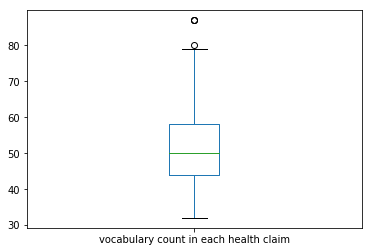

In [13]:
pd.DataFrame(pd.Series(hc_len).sort_values().values,columns=['vocabulary count in each health claim']).plot.box()

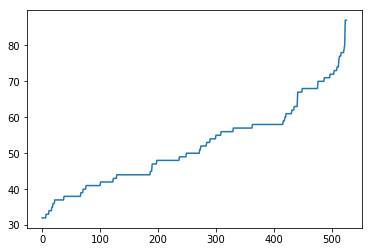

In [163]:
pd.Series(pd.Series(hc_len).sort_values().values).plot()

In [166]:
pd.DataFrame(all_words.most_common(10))

,0,1
0,.,526
1,healthy,288
2,of,277
3,the,223
4,maintenance,223
5,is,147
6,for,147
7,to,140
8,calcium,136
9,bones,136


In [14]:
# Remove stop words and punctuations for word cloud text 
wordCloudText = {}
for i in all_words.items():
    if i[0] not in stopwordEn and i[0].isalpha():
        wordCloudText[i[0]] = i[1]

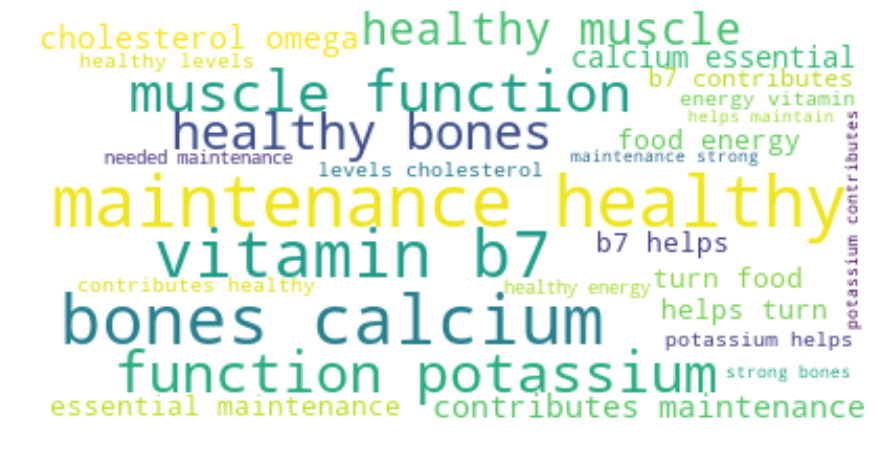

In [15]:
# word cloud
# https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
# % matplotlib inline

wordcloud = WordCloud(max_font_size=100, min_font_size=8, max_words=100, background_color="white").generate(' '.join(all_hc_words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

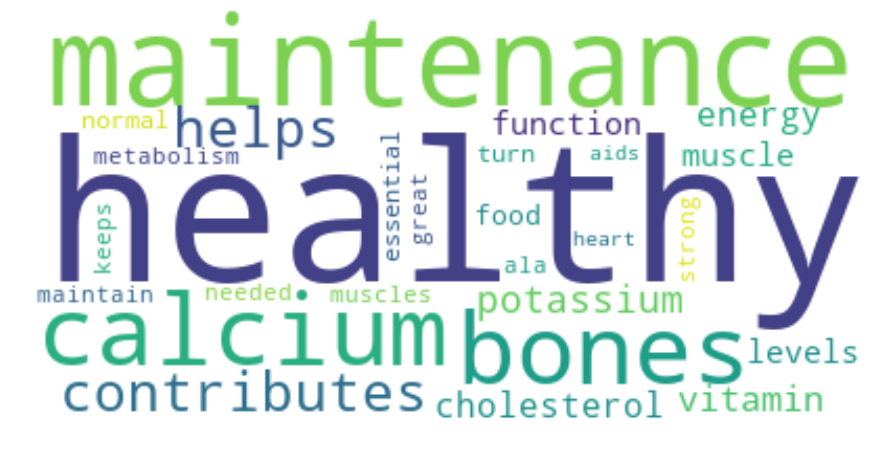

In [190]:
wordCloudText# word cloud
# https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
# % matplotlib inline

wordcloud = WordCloud(max_font_size=300, min_font_size=10, max_words=100, background_color="white").generate_from_frequencies(wordCloudText)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# De-duplicate HC

In [16]:
# Unique HC
hc_cus_count = pd.DataFrame({'counts':df_hc_cus.groupby('hc')['hc'].count().sort_values(ascending=False)})
hc_cus_count.shape,hc_cus_count.head()

((97, 1),                                                     counts
 hc                                                        
 vitamin b7 helps turn your food into energy.            52
 calcium is essential for the maintenance of hea...      37
 potassium contributes to the maintenance of hea...      27
 potassium aids in healthy muscle function.              21
 potassium helps support healthy muscle function.        20)

Text(0, 0.5, 'HC')

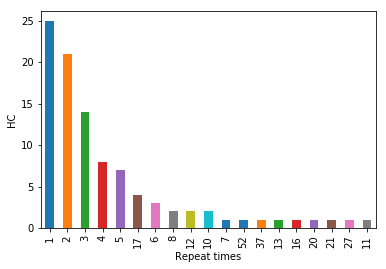

In [13]:
hc_cus_count.counts.value_counts().plot.bar()
plt.xlabel('Repeat times')
plt.ylabel('HC')

In [17]:
def getPos(hc, seq=True):
    postagging = nltk.pos_tag(word_tokenize(hc))
    hc_tag = [i[1] for i in postagging] if seq else [i for i in postagging]
    return hc_tag

In [18]:
hc_cus_count.loc[:,'pos'] = hc_cus_count.index.map(getPos)
hc_cus_count.loc[:,'hc_tagged'] = [getPos(i, False) for i in hc_cus_count.index]
hc_cus_count['hc'] = hc_cus_count.index
hc_cus_count.index = pd.Index(range(len(hc_cus_count)))

In [19]:
hc_cus_count.head()

,counts,pos,hc_tagged,hc
0,52,"[NN, NN, VBZ, VB, PRP$, NN, IN, NN, .]","[(vitamin, NN), (b7, NN), (helps, VBZ), (turn,...",vitamin b7 helps turn your food into energy.
1,37,"[NN, VBZ, JJ, IN, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (is, VBZ), (essential, JJ), (f...",calcium is essential for the maintenance of he...
2,27,"[NN, VBZ, TO, DT, NN, IN, JJ, NN, NN, .]","[(potassium, NN), (contributes, VBZ), (to, TO)...",potassium contributes to the maintenance of he...
3,21,"[NN, NNS, IN, JJ, NN, NN, .]","[(potassium, NN), (aids, NNS), (in, IN), (heal...",potassium aids in healthy muscle function.
4,20,"[NN, VBZ, VB, JJ, NN, NN, .]","[(potassium, NN), (helps, VBZ), (support, VB),...",potassium helps support healthy muscle function.


In [20]:
with open('df_hc_cus.pickle', 'wb') as handle:
    pickle.dump(hc_cus_count, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [208]:
drawTree(hc_cus_count.hc_tagged[88])

In [17]:
# Graph-based FP mining edges即为共现序列
def buildEdges(df, k=2, minS=10, raw=False, unique=False):  
# l为输入的序列集合， k是序列中行为的个数 默认为2，minS是最小支持度 默认为10, 若raw为真返回原始全部dict数据
  edges = {}
  for r in range(len(df)):
    s = df.pos[r]
    counts = df.counts[r] if unique==False else 1
    s=s[:] # make a copy of s
    s.insert(0,'s') # start notation
    for i in range(len(s)):
      if i+ k <= len(s):
        edge = '-'.join(s[i:i+k])
        if edge in edges:
          edges[edge] += counts
        else:
          edges[edge] = counts
  
  df_edges = pd.DataFrame(edges,index=['Support']).T.sort_values(by=['Support'],ascending=False)
  stat = {'TotalCombinations':len(df_edges),'min':df_edges['Support'].min(),
          'median':df_edges['Support'].median(),'mean':df_edges['Support'].mean(),
          'max':df_edges['Support'].max()
         }
  return (df_edges[df_edges['Support']>minS],pd.DataFrame([stat])) if raw==False else edges
# 输出为tuple, [0]项为dataframe结果，[1]为全部组合的统计数据

In [149]:
buildEdges(hc_cus_count, 2, 100, unique=False)[0]

,Support
s-NN,438
NN-VBZ,404
NN-IN,300
NN-.,272
NN-NN,257
IN-JJ,252
DT-NN,229
JJ-NNS,228
NNS-.,193
JJ-NN,190


In [150]:
buildEdges(hc_cus_count, 3, 100, unique=False)[0]

,Support
s-NN-VBZ,282
DT-NN-IN,229
NN-IN-JJ,223
IN-JJ-NNS,167
JJ-NNS-.,155
IN-DT-NN,137
JJ-NN-NN,124
s-NN-NN,120
NN-NN-VBZ,120
NN-NN-.,114


In [151]:
buildEdges(hc_cus_count, 4, 100, unique=False)[0]

,Support
DT-NN-IN-JJ,223
NN-IN-JJ-NNS,167
IN-DT-NN-IN,137
IN-JJ-NNS-.,132
s-NN-NN-VBZ,120
VBZ-JJ-IN-DT,108
JJ-NN-NN-.,107
NN-VBZ-JJ-IN,102
s-NN-VBZ-JJ,101


In [152]:
buildEdges(hc_cus_count, 5, 100, unique=False)[0]

,Support
DT-NN-IN-JJ-NNS,167
IN-DT-NN-IN-JJ,137
NN-IN-JJ-NNS-.,132
NN-VBZ-JJ-IN-DT,102
s-NN-VBZ-JJ-IN,101


In [154]:
buildEdges(hc_cus_count, 6, 80, unique=False)[0]

,Support
DT-NN-IN-JJ-NNS-.,132
IN-DT-NN-IN-JJ-NNS,123
s-NN-VBZ-JJ-IN-DT,101
VBZ-JJ-IN-DT-NN-IN,92
JJ-IN-DT-NN-IN-JJ,92
NN-VBZ-JJ-IN-DT-NN,89


In [155]:
buildEdges(hc_cus_count, 7, 80, unique=False)[0]

,Support
IN-DT-NN-IN-JJ-NNS-.,97
VBZ-JJ-IN-DT-NN-IN-JJ,92
s-NN-VBZ-JJ-IN-DT-NN,89
NN-VBZ-JJ-IN-DT-NN-IN,89
JJ-IN-DT-NN-IN-JJ-NNS,88


In [158]:
buildEdges(hc_cus_count, 9, 50, unique=False)[0]

,Support
s-NN-VBZ-JJ-IN-DT-NN-IN-JJ,89
NN-VBZ-JJ-IN-DT-NN-IN-JJ-NNS,87
VBZ-JJ-IN-DT-NN-IN-JJ-NNS-.,76
s-NN-NN-VBZ-VB-PRP$-NN-IN-NN,52
NN-NN-VBZ-VB-PRP$-NN-IN-NN-.,52


In [11]:
# FP mining for words 即为共现序列
def buildEdgesWord(df, k=2, minS=10, raw=False, unique=False):  
# l为输入的序列集合， k是序列中行为的个数 默认为2，minS是最小支持度 默认为10, 若raw为真返回原始全部dict数据
  edges = {}
  for r in range(len(df)):
    s = word_tokenize(df.hc[r])
    s = [get_lemma(w) for w in s]
    counts = df.counts[r] if unique==False else 1
    s.insert(0,'s') # start notation
    for i in range(len(s)):
      if i+ k <= len(s):
        edge = '-'.join(s[i:i+k])
        if edge in edges:
          edges[edge] += counts
        else:
          edges[edge] = counts
  
  df_edges = pd.DataFrame(edges,index=['Support']).T.sort_values(by=['Support'],ascending=False)
  stat = {'TotalCombinations':len(df_edges),'min':df_edges['Support'].min(),
          'median':df_edges['Support'].median(),'mean':df_edges['Support'].mean(),
          'max':df_edges['Support'].max()
         }
  return (df_edges[df_edges['Support']>minS],pd.DataFrame([stat])) if raw==False else edges
# 输出为tuple, [0]项为dataframe结果，[1]为全部组合的统计数据

In [14]:
buildEdgesWord(hc_cus_count, 2, 100, unique=False)[0]

,Support
maintenance-of,223
the-maintenance,223
of-healthy,144
s-calcium,136
bones-.,135
for-the,131
contribute-to,130
s-potassium,129
s-vitamin,120
vitamin-b7,120


In [16]:
buildEdgesWord(hc_cus_count, 3, 80, unique=False)[0]

,Support
the-maintenance-of,223
maintenance-of-healthy,144
for-the-maintenance,131
s-vitamin-b7,120
s-calcium-be,91
muscle-function-.,88
healthy-bones-.,85
of-healthy-bones,82


In [20]:
buildEdgesWord(hc_cus_count, 4, 60, unique=False)[0]

,Support
the-maintenance-of-healthy,144
for-the-maintenance-of,131
of-healthy-bones-.,82
maintenance-of-healthy-bones,82
to-the-maintenance-of,72
contribute-to-the-maintenance,72
healthy-muscle-function-.,68


In [25]:
buildEdgesWord(hc_cus_count, 5, 50, unique=False)[0]

,Support
maintenance-of-healthy-bones-.,82
the-maintenance-of-healthy-bones,82
for-the-maintenance-of-healthy,80
contribute-to-the-maintenance-of,72
s-calcium-be-essential-for,57
calcium-be-essential-for-the,57
be-essential-for-the-maintenance,57
essential-for-the-maintenance-of,57
help-turn-your-food-into,53
turn-your-food-into-energy,53


In [24]:
buildEdgesWord(hc_cus_count, 6, 50, unique=False)[0]

,Support
the-maintenance-of-healthy-bones-.,82
s-calcium-be-essential-for-the,57
calcium-be-essential-for-the-maintenance,57
be-essential-for-the-maintenance-of,57
for-the-maintenance-of-healthy-bones,54
contribute-to-the-maintenance-of-healthy,53
help-turn-your-food-into-energy,53
turn-your-food-into-energy-.,53
s-vitamin-b7-help-turn-your,52
b7-help-turn-your-food-into,52


In [26]:
buildEdgesWord(hc_cus_count, 7, 50, unique=False)[0]

,Support
s-calcium-be-essential-for-the-maintenance,57
calcium-be-essential-for-the-maintenance-of,57
for-the-maintenance-of-healthy-bones-.,54
help-turn-your-food-into-energy-.,53
s-vitamin-b7-help-turn-your-food,52
b7-help-turn-your-food-into-energy,52
vitamin-b7-help-turn-your-food-into,52


In [27]:
buildEdgesWord(hc_cus_count, 8, 50, unique=False)[0]

,Support
s-calcium-be-essential-for-the-maintenance-of,57
s-vitamin-b7-help-turn-your-food-into,52
vitamin-b7-help-turn-your-food-into-energy,52
b7-help-turn-your-food-into-energy-.,52


# Mapping

In [29]:
with open('df_hc_manu.pickle', 'rb') as handle:
    df_hc_manu = pickle.load(handle)
df_hc_manu.loc[:,'pos'] = df_hc_manu.hc.map(getPos)

with open('cat_hc.pickle', 'rb') as handle:
    cat_hc = pickle.load(handle)
    

In [232]:
df_hc_manu.head()

,hc,nutrient,nutrient_num,pos
0,bones: vitamin d supports normal bones.,[vitamin d],1,"[NNS, :, NN, NN, VBZ, JJ, NNS, .]"
1,bones: vitamin d supports the maintenance of n...,[vitamin d],1,"[NNS, :, NN, NN, VBZ, DT, NN, IN, JJ, NNS, .]"
2,brain: dha supports normal brain function.,[],0,"[NN, :, JJ, NNS, JJ, NN, NN, .]"
3,calcium & vitamin d support normal bones.,"[calcium, vitamin d]",2,"[NN, CC, NN, JJ, NN, JJ, NNS, .]"
4,dha supports normal brain function.,[],0,"[NN, NNS, JJ, NN, NN, .]"


In [6]:
cat_hc.head()

,approved_hc_ID,approved_count,manu_hc_ID,manu_count
nutrient,,,,
activated charcoal,[1],1,[],0
alpha-cyclodextrin,[31],1,[],0
alpha-linolenic acid (ala),[0],1,[],0
"alpha-linolenic acid (ala) & linoleic acid (la), essential fatty acids",[254],1,[],0
arabinoxylan produced from wheat endosperm,[32],1,[],0


## Map to approved nutrient (failed)
ONLY 3 nutrients have been matched

In [203]:
#Mapping
cat_hc.loc[:,'cus_hc_ID'] = [list(hc_cus_count.index[hc_cus_count['hc'].str.contains(n)]) for n in cat_hc.index]
cat_hc.loc[:,'cus_hc_count'] = [len(i) for i in cat_hc['cus_hc_ID']]
cat_hc.head(5)

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,approved_hc_ID,approved_count,manu_hc_ID,manu_count,cus_hc_ID,cus_hc_count
nutrient,,,,,,
activated charcoal,[1],1,[],0,[],0
alpha-cyclodextrin,[31],1,[],0,[],0
alpha-linolenic acid (ala),[0],1,[],0,[],0
"alpha-linolenic acid (ala) & linoleic acid (la), essential fatty acids",[254],1,[],0,[],0
arabinoxylan produced from wheat endosperm,[32],1,[],0,[],0


In [207]:
cat_hc['cus_hc_count'].value_counts()

0     84
20     1
14     1
7      1
Name: cus_hc_count, dtype: int64

In [208]:
cat_hc[cat_hc['cus_hc_count']>0] # only 3 nutrents were matched to the consumers' HC

,approved_hc_ID,approved_count,manu_hc_ID,manu_count,cus_hc_ID,cus_hc_count
nutrient,,,,,,
biotin,"[5, 6, 7, 8, 9, 10, 11]",7,"[62, 170, 204, 205, 206, 207, 208, 209, 210, 2...",101,"[27, 55, 56, 72, 73, 74, 80]",7
calcium,"[12, 13, 14, 15, 16, 17, 18, 19, 237, 250]",10,"[3, 42, 61, 80, 81, 82, 83, 84, 92, 101, 113, ...",435,"[1, 5, 7, 11, 16, 17, 22, 24, 33, 38, 42, 43, ...",20
potassium,"[121, 122, 123]",3,"[33, 66, 67, 110, 452, 762, 763, 1084, 1085, 1...",67,"[2, 3, 4, 9, 10, 21, 26, 31, 32, 34, 47, 59, 6...",14


In [213]:
hc_cus_count[hc_cus_count['hc'].str.contains('vitamin')]

,count,pos,hc_tagged,hc
0,52,"[NN, NN, VBZ, VB, PRP$, NN, IN, NN, .]","[(vitamin, NN), (b7, NN), (helps, VBZ), (turn,...",vitamin b7 helps turn your food into energy.
6,17,"[NN, NN, VBZ, PRP$, NN, VBG, .]","[(vitamin, NN), (b7, NN), (gets, VBZ), (your, ...",vitamin b7 gets your metabolism going.
8,17,"[NN, NN, VBZ, TO, JJ, NN, NNS, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to healthy energy levels.
15,10,"[NN, NN, VBZ, TO, JJ, NN, NN, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to healthy energy metab...
28,5,"[NN, NN, VBZ, TO, JJ, JJ, NN, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to healthy energy-yield...
30,4,"[NN, NN, VBZ, TO, JJ, NN, IN, NN, IN, NN, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to normal release of en...
35,4,"[NN, NN, VBZ, TO, JJ, NN, NN, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to healthy energy release.
36,4,"[NN, NN, VBZ, TO, JJ, NN, IN, NN, IN, NN, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to healthy release of e...
48,3,"[NN, NN, VBZ, TO, JJ, NN, NNS, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to normal energy levels.
64,2,"[NN, NN, VBZ, TO, JJ, JJ, NN, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to normal energy-yieldi...


## Map to US nutrients databse

In [84]:
with open('df_nu.pickle', 'rb') as handle:
    df_nu = pickle.load(handle)
df_nu.head()

,id,name,unit_name,nutrient_nbr,rank,nutrients,alias_count
0,1002,Nitrogen,G,202.0,500.0,[nitrogen],1
1,1003,Protein,G,203.0,600.0,[protein],1
2,1004,Total lipid (fat),G,204.0,800.0,"[fat, total lipid]",2
3,1005,"Carbohydrate, by difference",G,205.0,1110.0,[carbohydrate],1
4,1007,Ash,G,207.0,1000.0,[ash],1


In [85]:
df_nu.nutrients[56:61]

56                [alpha-tocopherol, vitamin e]
57    [d2 + d3, vitamin d, international units]
58                 [ergocalciferol, vitamin d2]
59                [cholecalciferol, vitamin d3]
60                  [25-hydroxycholecalciferol]
Name: nutrients, dtype: object

In [86]:
df_nu.shape

(235, 7)

In [87]:
len(hc_cus_count.index[hc_cus_count['hc'].str.contains('dha')])

0

In [88]:
df_nu.nutrients[150:153]

150    [dha, 22:6 n-3]
151            [22:00]
152            [14:01]
Name: nutrients, dtype: object

In [89]:
hc_ids = []
for r in df_nu.nutrients:
    hc_id = []
    for n in r:
        if len(n) >= 3:
            hc_id.extend(hc_cus_count.index[hc_cus_count['hc'].str.contains(n)])
        else:
            hc_id.extend([i for i in list(hc_cus_count.index) if nltk.pos_tag([n])[0] in hc_cus_count['hc_tagged'][i]])
    hc_ids.append(list(hc_id))
df_nu.loc[:,'hc_ids'] = list(hc_ids)
df_nu.loc[:,'id_num'] = [len(i) for i in df_nu.hc_ids]
df_nu.head(10)

,id,name,unit_name,nutrient_nbr,rank,nutrients,alias_count,hc_ids,id_num
0,1002,Nitrogen,G,202.0,500.0,[nitrogen],1,[],0
1,1003,Protein,G,203.0,600.0,[protein],1,[],0
2,1004,Total lipid (fat),G,204.0,800.0,"[fat, total lipid]",2,[],0
3,1005,"Carbohydrate, by difference",G,205.0,1110.0,[carbohydrate],1,[],0
4,1007,Ash,G,207.0,1000.0,[ash],1,[],0
5,1008,Energy,KCAL,208.0,300.0,[energy],1,"[0, 8, 15, 28, 30, 35, 36, 48, 55, 56, 64, 71,...",16
6,1009,Starch,G,209.0,2200.0,[starch],1,[],0
7,1010,Sucrose,G,210.0,1600.0,[sucrose],1,[],0
8,1011,Glucose (dextrose),G,211.0,1700.0,"[dextrose, glucose]",2,[],0
9,1012,Fructose,G,212.0,1800.0,[fructose],1,[],0


In [90]:
df_nu.id_num.value_counts()

0     224
3       3
20      2
16      2
37      1
14      1
7       1
5       1
Name: id_num, dtype: int64

In [91]:
hc_cus_count.loc[:,'nutrient'] = [[cat_index for cat_index in df_nu.index if hc in df_nu['hc_ids'][cat_index]] for hc in hc_cus_count.index]
hc_cus_count.loc[:,'nutrient_num'] = [len(i) for i in hc_cus_count['nutrient']]
hc_cus_count.head(10)

,counts,pos,hc_tagged,hc,nutrient,nutrient_num
0,52,"[NN, NN, VBZ, VB, PRP$, NN, IN, NN, .]","[(vitamin, NN), (b7, NN), (helps, VBZ), (turn,...",vitamin b7 helps turn your food into energy.,"[5, 23, 98]",3
1,37,"[NN, VBZ, JJ, IN, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (is, VBZ), (essential, JJ), (f...",calcium is essential for the maintenance of he...,[34],1
2,27,"[NN, VBZ, TO, DT, NN, IN, JJ, NN, NN, .]","[(potassium, NN), (contributes, VBZ), (to, TO)...",potassium contributes to the maintenance of he...,[39],1
3,21,"[NN, NNS, IN, JJ, NN, NN, .]","[(potassium, NN), (aids, NNS), (in, IN), (heal...",potassium aids in healthy muscle function.,[39],1
4,20,"[NN, VBZ, VB, JJ, NN, NN, .]","[(potassium, NN), (helps, VBZ), (support, VB),...",potassium helps support healthy muscle function.,[39],1
5,17,"[NN, VBZ, TO, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (contributes, VBZ), (to, TO), ...",calcium contributes to the maintenance of heal...,[34],1
6,17,"[NN, NN, VBZ, PRP$, NN, VBG, .]","[(vitamin, NN), (b7, NN), (gets, VBZ), (your, ...",vitamin b7 gets your metabolism going.,[],0
7,17,"[NN, VBZ, JJ, IN, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (is, VBZ), (essential, JJ), (f...",calcium is essential for the maintenance of st...,[34],1
8,17,"[NN, NN, VBZ, TO, JJ, NN, NNS, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to healthy energy levels.,"[5, 23]",2
9,16,"[NN, VBZ, VB, JJ, NNS, .]","[(potassium, NN), (helps, VBZ), (maintain, VB)...",potassium helps maintain healthy muscles.,[39],1


In [92]:
hc_cus_count.nutrient_num.value_counts()

1    54
2    25
3     8
0     6
4     4
Name: nutrient_num, dtype: int64

In [93]:
hc_cus_count.hc[7]

'calcium is essential for the maintenance of strong bones.'

In [94]:
df_nu.nutrients[hc_cus_count.nutrient[7]]

34    [calcium, ca]
Name: nutrients, dtype: object

## Map to UK nutrients database

In [96]:
with open('df_uknu.pickle', 'rb') as handle:
    df_uknu = pickle.load(handle)
df_uknu.head()

,nutrients,unit,nu_num
0,[water],G,1
1,"[total nitrogen, totnit]",G,2
2,"[protein, prot]",G,2
3,[fat],G,1
4,"[carbohydrate, cho]",G,2


In [97]:
df_uknu.shape

(272, 3)

In [98]:
hc_cus_count.head()

,counts,pos,hc_tagged,hc,nutrient,nutrient_num
0,52,"[NN, NN, VBZ, VB, PRP$, NN, IN, NN, .]","[(vitamin, NN), (b7, NN), (helps, VBZ), (turn,...",vitamin b7 helps turn your food into energy.,"[5, 23, 98]",3
1,37,"[NN, VBZ, JJ, IN, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (is, VBZ), (essential, JJ), (f...",calcium is essential for the maintenance of he...,[34],1
2,27,"[NN, VBZ, TO, DT, NN, IN, JJ, NN, NN, .]","[(potassium, NN), (contributes, VBZ), (to, TO)...",potassium contributes to the maintenance of he...,[39],1
3,21,"[NN, NNS, IN, JJ, NN, NN, .]","[(potassium, NN), (aids, NNS), (in, IN), (heal...",potassium aids in healthy muscle function.,[39],1
4,20,"[NN, VBZ, VB, JJ, NN, NN, .]","[(potassium, NN), (helps, VBZ), (support, VB),...",potassium helps support healthy muscle function.,[39],1


In [99]:
hc_ids = []
for r in df_uknu.nutrients:
    hc_id = []
    for n in r:
        if len(n) >= 3:
            hc_id.extend(hc_cus_count.index[hc_cus_count['hc'].str.contains(n)])
        else:
            hc_id.extend([i for i in list(hc_cus_count.index) if nltk.pos_tag([n])[0] in hc_cus_count['hc_tagged'][i]])
    hc_ids.append(list(hc_id))
df_uknu.loc[:,'hc_ids'] = list(hc_ids)
df_uknu.loc[:,'id_num'] = [len(i) for i in df_uknu.hc_ids]
df_uknu.head()

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,nutrients,unit,nu_num,hc_ids,id_num
0,[water],G,1,[],0
1,"[total nitrogen, totnit]",G,2,[],0
2,"[protein, prot]",G,2,[],0
3,[fat],G,1,[],0
4,"[carbohydrate, cho]",G,2,"[13, 14, 18, 19, 23, 25, 29, 37, 39, 40, 41, 4...",37


In [100]:
df_uknu.id_num.value_counts()

0     263
40      3
14      2
74      1
37      1
20      1
16      1
Name: id_num, dtype: int64

In [102]:
hc_cus_count.loc[:,'nutrient_uk'] = [[cat_index for cat_index in df_uknu.index if hc in df_uknu['hc_ids'][cat_index]] for hc in hc_cus_count.index]
hc_cus_count.loc[:,'nutrient_num_uk'] = [len(i) for i in hc_cus_count['nutrient_uk']]
hc_cus_count.head(10)

,counts,pos,hc_tagged,hc,nutrient,nutrient_num,nutrient_uk,nutrient_num_uk
0,52,"[NN, NN, VBZ, VB, PRP$, NN, IN, NN, .]","[(vitamin, NN), (b7, NN), (helps, VBZ), (turn,...",vitamin b7 helps turn your food into energy.,"[5, 23, 98]",3,[5],1
1,37,"[NN, VBZ, JJ, IN, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (is, VBZ), (essential, JJ), (f...",calcium is essential for the maintenance of he...,[34],1,"[39, 41, 90, 117]",4
2,27,"[NN, VBZ, TO, DT, NN, IN, JJ, NN, NN, .]","[(potassium, NN), (contributes, VBZ), (to, TO)...",potassium contributes to the maintenance of he...,[39],1,"[39, 40, 90, 117]",4
3,21,"[NN, NNS, IN, JJ, NN, NN, .]","[(potassium, NN), (aids, NNS), (in, IN), (heal...",potassium aids in healthy muscle function.,[39],1,[40],1
4,20,"[NN, VBZ, VB, JJ, NN, NN, .]","[(potassium, NN), (helps, VBZ), (support, VB),...",potassium helps support healthy muscle function.,[39],1,[40],1
5,17,"[NN, VBZ, TO, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (contributes, VBZ), (to, TO), ...",calcium contributes to the maintenance of heal...,[34],1,"[39, 41, 90, 117]",4
6,17,"[NN, NN, VBZ, PRP$, NN, VBG, .]","[(vitamin, NN), (b7, NN), (gets, VBZ), (your, ...",vitamin b7 gets your metabolism going.,[],0,[],0
7,17,"[NN, VBZ, JJ, IN, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (is, VBZ), (essential, JJ), (f...",calcium is essential for the maintenance of st...,[34],1,"[39, 41, 90, 117]",4
8,17,"[NN, NN, VBZ, TO, JJ, NN, NNS, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to healthy energy levels.,"[5, 23]",2,[5],1
9,16,"[NN, VBZ, VB, JJ, NNS, .]","[(potassium, NN), (helps, VBZ), (maintain, VB)...",potassium helps maintain healthy muscles.,[39],1,[40],1


In [75]:
hc_cus_count.nutrient_num.value_counts()

2    24
1    24
4    21
5    19
0     9
Name: nutrient_num, dtype: int64

In [76]:
hc_cus_count.hc[7]

'calcium is essential for the maintenance of strong bones.'

In [77]:
df_nu.nutrients[hc_cus_count.nutrient[7]]

39      [potassium, k]
41         [sulfur, s]
90     [folate, total]
117         [tyrosine]
Name: nutrients, dtype: object

## Map to Combined nutrients data

In [103]:
with open('df_comb_nu.pickle', 'rb') as handle:
    df_comb_nu = pickle.load(handle)
df_comb_nu.head()

,nutrients,nu_num
0,[water],1
1,"[total nitrogen, totnit]",2
2,"[protein, prot]",2
3,[fat],1
4,"[carbohydrate, cho]",2


In [7]:
len(df_comb_nu)

458

In [112]:
df_comb_nu.iloc[39]

nutrients                                        [sodium, nan]
nu_num                                                       2
hc_ids       [1, 2, 5, 7, 11, 13, 14, 16, 17, 19, 22, 23, 2...
id_num                                                      40
Name: 39, dtype: object

In [105]:
hc_ids = []
for r in df_comb_nu.nutrients:
    hc_id = []
    for n in r:
        if len(n) > 2:
            hc_id.extend(hc_cus_count.index[hc_cus_count['hc'].str.contains(n)])
        else:
            new_ids = [i for i in list(hc_cus_count.index) if nltk.pos_tag([n])[0] in hc_cus_count['hc_tagged'][i]]
            hc_id.extend(new_ids)
#             print(n,new_ids)
    hc_ids.append(list(hc_id))
df_comb_nu.loc[:,'hc_ids'] = list(hc_ids)
df_comb_nu.loc[:,'id_num'] = [len(i) for i in df_comb_nu.hc_ids]
df_comb_nu.head(10)

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,nutrients,nu_num,hc_ids,id_num
0,[water],1,[],0
1,"[total nitrogen, totnit]",2,[],0
2,"[protein, prot]",2,[],0
3,[fat],1,[],0
4,"[carbohydrate, cho]",2,"[13, 14, 18, 19, 23, 25, 29, 37, 39, 40, 41, 4...",37
5,"[energy, kcals, kcal]",3,"[0, 8, 15, 28, 30, 35, 36, 48, 55, 56, 64, 71,...",16
6,"[starch, star]",2,[],0
7,"[oligosaccharide, oligo]",2,[],0
8,"[total sugars, totsug]",2,[],0
9,"[glucose, gluc]",2,[],0


In [106]:
df_comb_nu.id_num.value_counts()

0     446
40      3
20      2
14      2
74      1
37      1
16      1
5       1
3       1
Name: id_num, dtype: int64

In [107]:
hc_cus_count.loc[:,'nutrient'] = [[cat_index for cat_index in df_comb_nu.index if hc in df_comb_nu['hc_ids'][cat_index]] for hc in hc_cus_count.index]
hc_cus_count.loc[:,'nutrient_num'] = [len(i) for i in hc_cus_count['nutrient']]
hc_cus_count.head(10)

,counts,pos,hc_tagged,hc,nutrient,nutrient_num,nutrient_uk,nutrient_num_uk
0,52,"[NN, NN, VBZ, VB, PRP$, NN, IN, NN, .]","[(vitamin, NN), (b7, NN), (helps, VBZ), (turn,...",vitamin b7 helps turn your food into energy.,"[5, 335]",2,[5],1
1,37,"[NN, VBZ, JJ, IN, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (is, VBZ), (essential, JJ), (f...",calcium is essential for the maintenance of he...,"[39, 41, 90, 117]",4,"[39, 41, 90, 117]",4
2,27,"[NN, VBZ, TO, DT, NN, IN, JJ, NN, NN, .]","[(potassium, NN), (contributes, VBZ), (to, TO)...",potassium contributes to the maintenance of he...,"[39, 40, 90, 117]",4,"[39, 40, 90, 117]",4
3,21,"[NN, NNS, IN, JJ, NN, NN, .]","[(potassium, NN), (aids, NNS), (in, IN), (heal...",potassium aids in healthy muscle function.,[40],1,[40],1
4,20,"[NN, VBZ, VB, JJ, NN, NN, .]","[(potassium, NN), (helps, VBZ), (support, VB),...",potassium helps support healthy muscle function.,[40],1,[40],1
5,17,"[NN, VBZ, TO, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (contributes, VBZ), (to, TO), ...",calcium contributes to the maintenance of heal...,"[39, 41, 90, 117]",4,"[39, 41, 90, 117]",4
6,17,"[NN, NN, VBZ, PRP$, NN, VBG, .]","[(vitamin, NN), (b7, NN), (gets, VBZ), (your, ...",vitamin b7 gets your metabolism going.,[],0,[],0
7,17,"[NN, VBZ, JJ, IN, DT, NN, IN, JJ, NNS, .]","[(calcium, NN), (is, VBZ), (essential, JJ), (f...",calcium is essential for the maintenance of st...,"[39, 41, 90, 117]",4,"[39, 41, 90, 117]",4
8,17,"[NN, NN, VBZ, TO, JJ, NN, NNS, .]","[(vitamin, NN), (b7, NN), (contributes, VBZ), ...",vitamin b7 contributes to healthy energy levels.,[5],1,[5],1
9,16,"[NN, VBZ, VB, JJ, NNS, .]","[(potassium, NN), (helps, VBZ), (maintain, VB)...",potassium helps maintain healthy muscles.,[40],1,[40],1


In [108]:
hc_cus_count.nutrient_num.value_counts()

1    24
4    21
2    15
3    12
6    10
5     9
0     6
Name: nutrient_num, dtype: int64

In [110]:
df_comb_nu.nutrients[hc_cus_count.nutrient[7]]

39                                [sodium, nan]
41                                [calcium, ca]
90       [c11:0 ex br /100g fa, fac11:0xb, nan]
117    [c11:0 ex br /100g food, fod11:0xb, nan]
Name: nutrients, dtype: object

In [111]:
hc_cus_count.hc[7]

'calcium is essential for the maintenance of strong bones.'

# Topic Modelling

In [13]:
#removing stop words
def get_lemma(word):
    lemma = wordnet.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

def getTokens(hc):
    tokens = word_tokenize(hc)
    tokens = [get_lemma(w).lower() for w in tokens if w not in stopwordEn and w.isalpha()]
    return tokens

In [210]:
text_data = []
for hc in df_hc_cus.hc:
    tokens = getTokens(hc)
    text_data.append(tokens)
len(text_data)

526

In [211]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [214]:
import gensim
NUM_TOPICS = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.264*"keep" + 0.169*"muscle" + 0.169*"potassium" + 0.169*"functioning" + 0.121*"properly"')
(1, '0.199*"calcium" + 0.199*"bones" + 0.196*"maintenance" + 0.120*"healthy" + 0.097*"essential"')
(2, '0.041*"maintenance" + 0.039*"bones" + 0.039*"calcium" + 0.028*"strong" + 0.028*"healthy"')
(3, '0.206*"metabolism" + 0.171*"vitamin" + 0.128*"contribute" + 0.108*"healthy" + 0.101*"going"')
(4, '0.190*"help" + 0.168*"potassium" + 0.168*"muscle" + 0.141*"healthy" + 0.093*"function"')
(5, '0.330*"normal" + 0.124*"contribute" + 0.115*"potassium" + 0.115*"muscle" + 0.114*"function"')
(6, '0.233*"healthy" + 0.205*"great" + 0.179*"heart" + 0.085*"cholesterol" + 0.082*"maintenance"')
(7, '0.168*"level" + 0.134*"cholesterol" + 0.125*"maintenance" + 0.115*"healthy" + 0.104*"contribute"')
(8, '0.208*"necessary" + 0.204*"bones" + 0.204*"calcium" + 0.177*"maintenance" + 0.146*"healthy"')
(9, '0.179*"muscle" + 0.179*"potassium" + 0.179*"function" + 0.147*"healthy" + 0.095*"maintenance"')
(10, '0.266*

In [215]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# Similarity

In [228]:
# the fraction of the same words out of the whole words of two compared hc
from nltk.corpus import wordnet
def get_lemma(word):
    lemma = wordnet.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

def getTokens(hc):
    tokens = word_tokenize(hc)
    tokens = [get_lemma(w).lower() for w in tokens if w not in stopwordEn and w.isalpha()]
    return tokens

def wordSim(hc, ahc): # input raw health claims text
    hc, ahc =  getTokens(hc), getTokens(ahc)
    hit = 0
    for w in hc: # 不忽略hc中的重复
        for aw in ahc:
            if w==aw:
                hit += 1
                break #不用break，max sim != 1，会加强重复的word, 用了break，忽略ahc中重复的word
#     return hit,len(hc),len(ahc)
    return hit,hit/((len(hc)+len(ahc))/2)

wordSim(df_hc_cus.hc[0], df_hc_res.hc[25]), wordSim(df_hc_cus.hc[0], df_hc_manu.hc[25])

((2, 0.4), (1, 0.14285714285714285))

In [224]:
df_hc_cus.hc[0]

'vitamin b7 contributes to healthy energy metabolism.'

In [227]:
df_hc_res.hc[25]

'choline contributes to normal homocysteine metabolism.'

In [223]:
df_hc_manu.hc[25]

'100% nrv of sunshine vitamin d: essential for the normal growth and development of bones in children.'

In [238]:
# the number of the same two-gram pos tagging 
def pos2Sim(hc_tag, ahc_tag): #input pos tag sequence
    # 2-gram
    hit = 0
    dic_at2={}
    for i in range(len(hc_tag)-1):
        t2 = (hc_tag[i], hc_tag[i+1])
        for p in range(len(ahc_tag)-1):
            at2 = (ahc_tag[p], ahc_tag[p+1])
            # del duplicate t2 in ahc
            if t2 == at2 and at2 not in dic_at2:
                dic_at2[at2] = True
                hit += 1
                break
    return hit, hit/((len(hc_tag)+len(ahc_tag)-2)/2)
pos2Sim(df_hc_cus.pos[0], df_hc_res.pos[25]), pos2Sim(df_hc_cus.pos[0], df_hc_manu.pos[25])

((5, 0.7692307692307693), (2, 0.15384615384615385))

In [247]:
# Average Similarity 遍历所有approved hc计算相似度，而非是通过nutrients查找
def avgSim(hc_ID):  #find similar approved hc, calculate avg sim, using pos tags in the df
    res_wordSim, res_pos2Sim = [],[]
    hc = df_hc_cus.hc[hc_ID]
    hc_pos = df_hc_cus.pos[hc_ID]
    for row in range(len(df_hc_res)):
        ahc = df_hc_res.hc[row]
        ahc_pos = df_hc_res.pos[row]
        res_wordSim.append(wordSim(hc, ahc)[1])
        res_pos2Sim.append(pos2Sim(hc_pos, ahc_pos)[1])
    res = pd.DataFrame({'wordSim':res_wordSim,'pos2Sim':res_pos2Sim,'avgSim':None}, index=range(len(df_hc_res)))
    res['avgSim'] = res.iloc[:,:2].mean(axis=1)
    return res.sort_values(by=['avgSim'], ascending=False)

In [279]:
QUERY_ID = 510
res = avgSim(QUERY_ID).head(10)
print('Query:',QUERY_ID,df_hc_cus.hc[QUERY_ID])
for i in res.index[:10]:
    print(i, df_hc_res.hc[i])

Query: 510 omega-3 contributes to the maintenance of normal blood cholesterol levels.
23 chitosan contributes to the maintenance of normal blood cholesterol levels.
0 ala contributes to the maintenance of normal blood cholesterol levels.
64 glucomannan contributes to the maintenance of normal blood cholesterol levels.
3 beta-glucans contribute to the maintenance of normal blood cholesterol levels.
115 pectins contribute to the maintenance of normal blood cholesterol levels.
67 hydroxypropyl methylcellulose contributes to the maintenance of normal blood cholesterol levels.
82 linoleic acid contributes to the maintenance of normal blood cholesterol levels.
120 plant sterols/stanols contribute to the maintenance of normal blood cholesterol levels.
51 dha contributes to the maintenance of normal blood triglyceride levels.
66 guar gum contributes to the maintenance of normal blood cholesterol levels.


In [275]:
res

,wordSim,pos2Sim,avgSim
3,0.833333,0.666667,0.750000
66,0.714286,0.727273,0.720779
0,0.769231,0.666667,0.717949
23,0.769231,0.666667,0.717949
64,0.769231,0.666667,0.717949
115,0.769231,0.666667,0.717949
120,0.769231,0.636364,0.702797
29,0.615385,0.761905,0.688645
82,0.714286,0.636364,0.675325
67,0.714286,0.636364,0.675325
